<a href="https://colab.research.google.com/github/anand-bidwalkar/SIT796-Reinforcement-Learning/blob/master/Task-2.2C/Task_2_2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SIT-796 Task-2.2 C Optimistic vs Realistic Initialization**

In [1]:
# install required system dependencies
!apt-get install -y xvfb x11-utils  
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* \
            gym[box2d]==0.17.* 
!pip install pyglet
!pip install ffmpeg
! pip install pyvirtualdisplay
!pip install Image
!pip install gym-maze-trustycoder83

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 993 kB in 1s (780 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.

In [1]:
!mkdir ./vid
!rm ./vid/*.*

rm: cannot remove './vid/*.*': No such file or directory


Import libraries for the environment

In [2]:
import sys
# import pygame
import numpy as np
# import math
# import base64
# import io
# import IPython
import gym
import gym_maze
# from gym.wrappers import Monitor
# from IPython import display
from pyvirtualdisplay import Display
from gym.wrappers.monitoring import video_recorder

In [4]:
# epsilon greedy algorithm
def eps_greedy(Q, s, eps=0.):
    if np.random.uniform(0,1) < eps:
        return np.random.randint(Q.shape[1])
    else:
        return int(np.argmax(Q[s]))

In [5]:
# Number of episode we will run
n_episodes = 10

# Maximum of iteration per episode
max_iter_episode = 500

# Initialize the exploration probability to 1
exploration_proba = 0.5

#Exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.001

# Minimum of exploration prob
min_exploration_proba = 0.01

# decay rate
eps_decay=0.00005

In [16]:
# Realisitic Initialisation
def realistic_intialisation(lr=0.1, gamma=0.95, eps=0.1):
  d = Display()
  d.start()

  # Recording filename
  video_name = "./vid/Maize.mp4"

  # Setup the environment for the maze
  env = gym.make("maze-sample-10x10-v0")

  # Setup the video
  vid = None
  vid = video_recorder.VideoRecorder(env,video_name)

  # env = gym.wrappers.Monitor(env,'./vid',force=True)
  current_state = env.reset()

  # store rewards for visualisation later
  cummulative_rewards_realistic = []

  states_dic = {} #dictionary to keep the states/coordinates of the Q table
  count = 0
  for i in range(10):
      for j in range(10):
          states_dic[i, j] = count
          count+=1
          
  n_actions = env.action_space.n

  # Initialize the Q-table to 0
  Q_table = np.zeros((len(states_dic),n_actions))

  # store rewards
  rewards_per_episode = list()

  # Iterate over episodes
  for e in range(n_episodes):
      
      # We are not done yet
      done = False
      
      # Sum the rewards that the agent gets from the environment
      total_episode_reward = 0

      for i in range(max_iter_episode): 
          env.unwrapped.render()
          vid.capture_frame()
          current_coordinate_x = int(current_state[0])
          current_coordinate_y = int(current_state[1])
          current_Q_table_coordinates = states_dic[current_coordinate_x, current_coordinate_y]

          # select an action following the eps-greedy policy
          action = eps_greedy(Q_table, current_Q_table_coordinates, eps=0.1)

          next_state, reward, done, _ = env.step(action)

          next_coordinate_x = int(next_state[0]) #get coordinates to be used in dictionary
          next_coordinate_y = int(next_state[1]) #get coordinates to be used in dictionary

          # get the max Q value for the next state
          next_Q_table_coordinates = states_dic[next_coordinate_x, next_coordinate_y]
          Q_table[current_Q_table_coordinates, action] = Q_table[current_Q_table_coordinates, action] + lr*(reward + gamma*np.max(max(Q_table[next_Q_table_coordinates,:]) - Q_table[current_Q_table_coordinates, action]))
          
          total_episode_reward += reward

          # rewards per steps
          rewards_per_episode.append(total_episode_reward)


          # If the episode is finished, we leave the for loop
          if done:
              break
          current_state = next_state

      #Show the total episode reward        
      print("Total episode reward:", total_episode_reward)

      cummulative_rewards_realistic.append(total_episode_reward)
      
      #Reset enviroment for next episode
      current_state = env.reset()

  # Save video episode and close
  print("Video successfuly saved.")
  vid.close()
  vid.enabled = False
  return cummulative_rewards_realistic

episode_realistic = realistic_intialisation()

Total episode reward: 0.6419999999999997
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: 0.6139999999999997
Total episode reward: 0.5849999999999997
Total episode reward: 0.6039999999999996
Total episode reward: 0.6349999999999998
Total episode reward: -0.5000000000000003
Total episode reward: 0.7769999999999998
Total episode reward: 0.7389999999999999
Video successfuly saved.


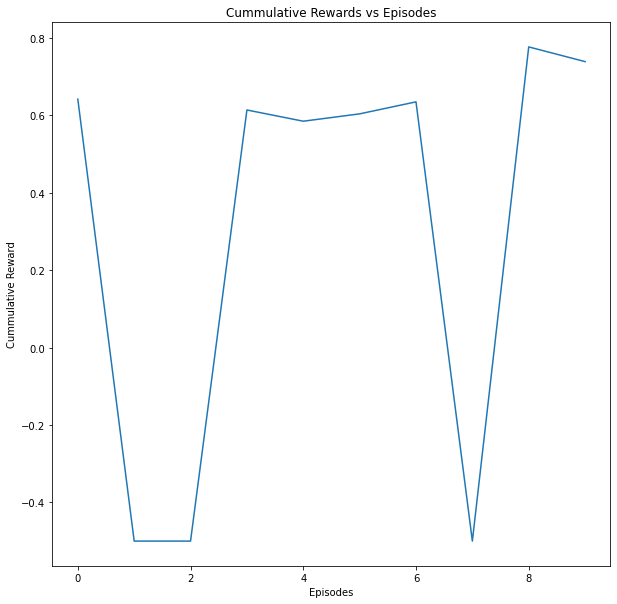

In [20]:
plt.figure(figsize=(10, 10))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Cummulative Reward')
plt.xlabel('Episodes')
plt.title('Cummulative Rewards vs Episodes')
plt.plot(episode_realistic)

In [23]:
def optimistic_initialisation(lr=0.1, gamma=0.95 ):
  !rm ./vid/*.*

  d = Display()
  d.start()

  # Recording filename
  video_name = "./vid/Maize.mp4"

  # Setup the environment for the maze
  env = gym.make("maze-sample-10x10-v0")

  # Setup the video
  vid = None
  vid = video_recorder.VideoRecorder(env,video_name)

  # env = gym.wrappers.Monitor(env,'./vid',force=True)
  current_state = env.reset()

  # store rewards for visualisation later
  cummulative_rewards_optimistic = []

  states_dic = {} #dictionary to keep the states/coordinates of the Q table
  count = 0
  for i in range(10):
      for j in range(10):
          states_dic[i, j] = count
          count+=1
          
  n_actions = env.action_space.n

  # Initialize the Q-table to 1 for optimistic intialisation
  Q_table = np.ones((len(states_dic), n_actions))

  # store rewards
  rewards_per_episode = list()

  # Iterate over episodes
  for e in range(n_episodes):
      
      # We are not done yet
      done = False
      
      # Sum the rewards that the agent gets from the environment
      total_episode_reward = 0

      for i in range(max_iter_episode): 
          env.unwrapped.render()
          vid.capture_frame()
          current_coordinate_x = int(current_state[0])
          current_coordinate_y = int(current_state[1])
          current_Q_table_coordinates = states_dic[current_coordinate_x, current_coordinate_y]

          # select an action following the eps-greedy policy
          action = eps_greedy(Q_table, current_Q_table_coordinates, eps=0.1)

          next_state, reward, done, _ = env.step(action)

          next_coordinate_x = int(next_state[0]) #get coordinates to be used in dictionary
          next_coordinate_y = int(next_state[1]) #get coordinates to be used in dictionary

          # get the max Q value for the next state
          next_Q_table_coordinates = states_dic[next_coordinate_x, next_coordinate_y]
          Q_table[current_Q_table_coordinates, action] = Q_table[current_Q_table_coordinates, action] + lr*(reward + gamma*np.max(max(Q_table[next_Q_table_coordinates,:]) - Q_table[current_Q_table_coordinates, action]))
          total_episode_reward += reward

          # store rewards per iteration
          rewards_per_episode.append(total_episode_reward)

          # If the episode is finished, we leave the for loop
          if done:
              break
          current_state = next_state

      #Show the total episode reward        
      print("Total episode reward:", total_episode_reward)

      cummulative_rewards_optimistic.append( total_episode_reward)
      
      #Reset enviroment for next episode
      current_state = env.reset()
      
      # Save video episode and close
  print("Video successfuly saved.")
  vid.close()
  vid.enabled = False
  return cummulative_rewards_optimistic

episode_optimistic = optimistic_initialisation()

Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: 0.6209999999999998
Total episode reward: 0.6729999999999998
Total episode reward: -0.5000000000000003
Total episode reward: 0.6639999999999997
Total episode reward: 0.7099999999999997
Total episode reward: -0.5000000000000003
Total episode reward: 0.7999999999999998
Video successfuly saved.


In [ ]:
import base64
import io
from IPython import display

video_name = "./vid/Maize.mp4"

video = io.open(video_name, 'r+b').read()
encoded = base64.b64encode(video)

display.display(display.HTML(data="""
  <video alt="test" controls>
  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
  </video>
  """.format(encoded.decode('ascii'))))

In [18]:
# when eps = 0.1
eps = 0.1
realistic_exp1 = realistic_intialisation(eps=0.1)

# when eps = 0.2
eps = 0.2
realistic_exp2 = realistic_intialisation(eps=0.2)

# when eps = 0.3
eps = 0.3
realistic_exp3 = realistic_intialisation(eps=0.3)

Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: 0.7869999999999998
Total episode reward: 0.5649999999999997
Total episode reward: -0.5000000000000003
Total episode reward: 0.7189999999999999
Total episode reward: 0.5839999999999996
Total episode reward: 0.6209999999999998
Total episode reward: 0.6459999999999997
Total episode reward: 0.7619999999999998
Video successfuly saved.
Total episode reward: 0.6559999999999997
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: 0.6639999999999997
Total episode reward: 0.6439999999999997
Total episode reward: 0.7319999999999998
Total episode reward: 0.6599999999999997
Total episode reward: 0.6769999999999998
Total episode reward: -0.5000000000000003
Video successfuly saved.
Total episode reward: 0.5549999999999997
Total episode reward: -0.5000000000000003
Total episode reward: -0.500000000000000

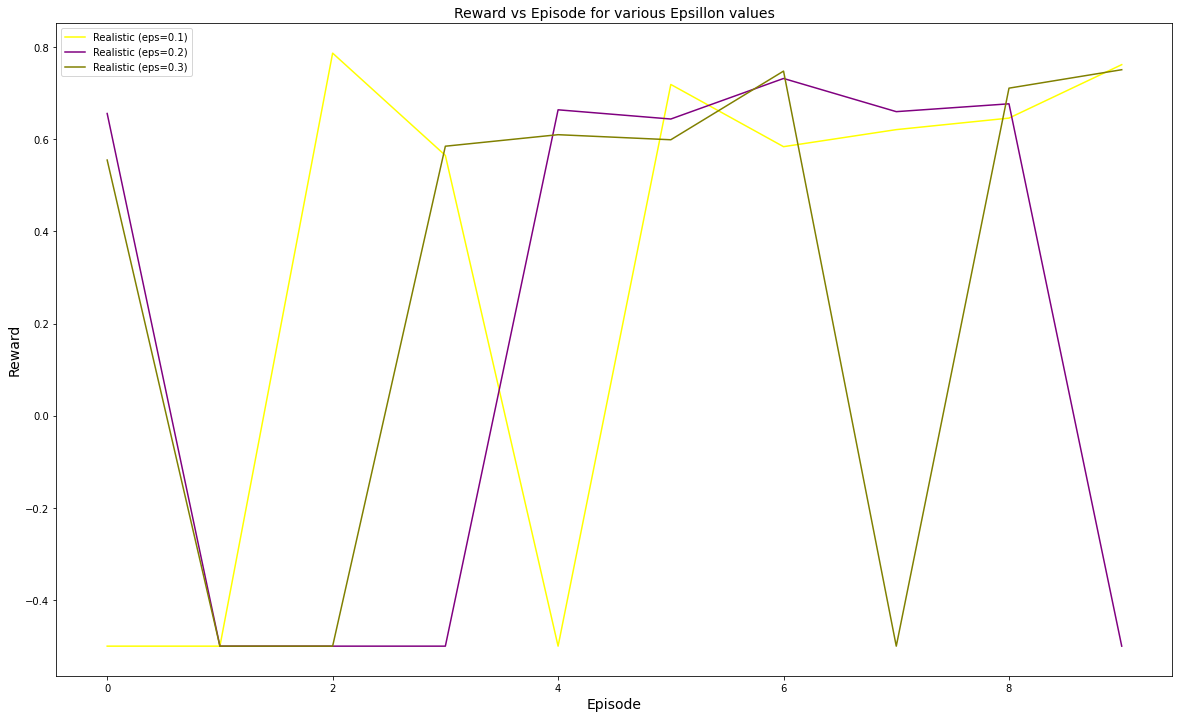

In [19]:
# visulisation for Reward vs Episode for various Epsillon values
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))

plt.plot(realistic_exp1, color='yellow',  label='Realistic (eps=0.1)')

plt.plot(realistic_exp2, color='purple',  label='Realistic (eps=0.2)')

plt.plot(realistic_exp3, color='olive', label='Realistic (eps=0.3)')

plt.title('Reward vs Episode for various Epsillon values', fontsize=14)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid(False)
plt.legend()
plt.show()

In [9]:
# when alpha = 0.1
alpha = 0.1
realistic_exp1 = realistic_initialisation(lr=0.1)
optimistic_exp1 = optimistic_initialisation(lr=0.1)

# when alpha = 0.2
alpha = 0.2
realistic_exp2 = realistic_initialisation(lr=0.2)
optimistic_exp2 = optimistic_initialisation(lr=0.2)

# when alpha = 0.3
alpha = 0.3
realistic_exp3 = realistic_initialisation(lr=0.3)
optimistic_exp3 = optimistic_initialisation(lr=0.3)

# when alpha = 0.4
alpha = 0.4
realistic_exp4 = realistic_initialisation(lr=0.4)
optimistic_exp4 = optimistic_initialisation(lr=0.4)

# when alpha = 0.5
alpha = 0.5
realistic_exp5 = realistic_initialisation(lr=0.5)
optimistic_exp5 = optimistic_initialisation(lr=0.5)

Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: 0.6059999999999997
Total episode reward: 0.5789999999999997
Total episode reward: 0.5069999999999997
Total episode reward: 0.7249999999999999
Total episode reward: 0.6669999999999998
Total episode reward: 0.5269999999999997
Total episode reward: -0.5000000000000003
Total episode reward: 0.8489999999999999
Video successfuly saved.
Total episode reward: 0.6409999999999998
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: 0.5759999999999996
Total episode reward: 0.6519999999999997
Total episode reward: 0.5709999999999997
Total episode reward: 0.7179999999999997
Total episode reward: 0.7629999999999998
Total episode reward: 0.7109999999999999
Total episode reward: 0.7829999999999998
Video successfuly saved.
Total episode reward: 0.5449999999999997
Total episode reward: -0.5000000000000003
Total episode reward: 0.6669999999999998
T

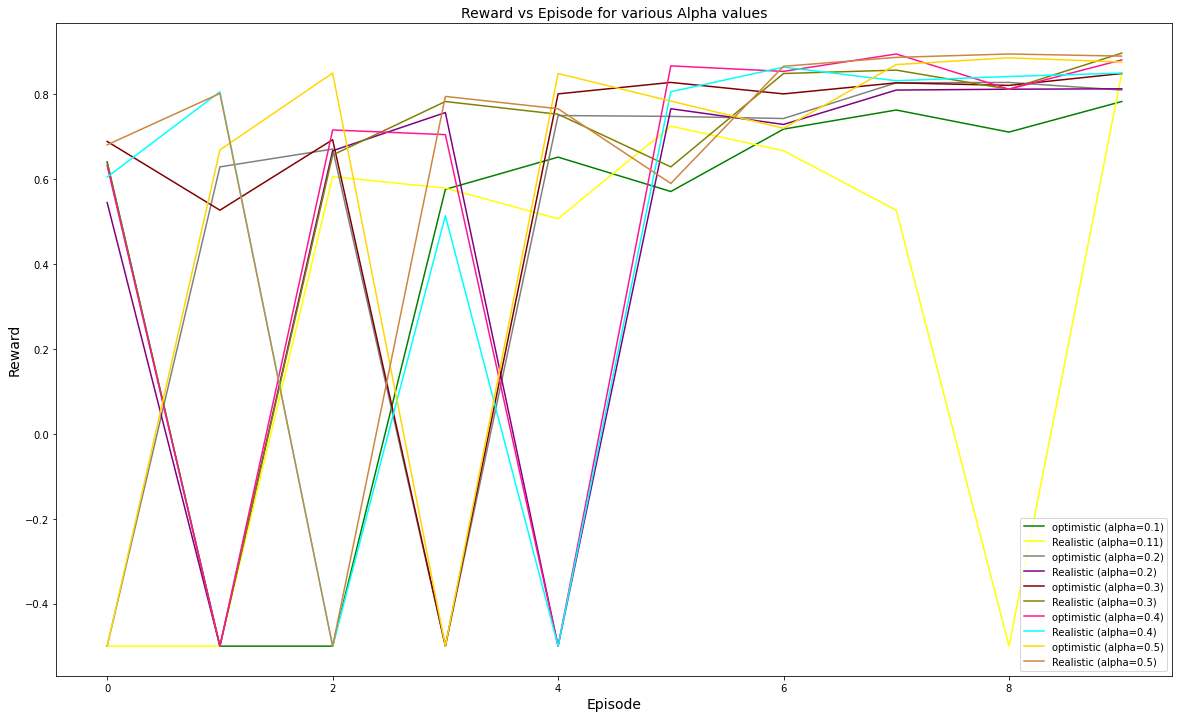

In [15]:
# visulisation for Reward vs Episode for various Alpha values
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))

plt.plot(optimistic_exp1, color='green', label = 'Optimistic (alpha=0.1)')
plt.plot(realistic_exp1, color='yellow',  label='Realistic (alpha=0.11)')

plt.plot(optimistic_exp2, color='grey',  label = 'Optimistic (alpha=0.2)')
plt.plot(realistic_exp2, color='purple',  label='Realistic (alpha=0.2)')

plt.plot(optimistic_exp3, color='maroon',  label = 'Optimistic (alpha=0.3)')
plt.plot(realistic_exp3, color='olive', label='Realistic (alpha=0.3)')

plt.plot(optimistic_exp4, color='deeppink',  label = 'Optimistic (alpha=0.4)')
plt.plot(realistic_exp4, color='cyan', label='Realistic (alpha=0.4)')

plt.plot(optimistic_exp5, color='gold',  label = 'Optimistic (alpha=0.5)')
plt.plot(realistic_exp5, color='peru',  label='Realistic (alpha=0.5)')

plt.title('Reward vs Episode for various Alpha values', fontsize=14)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid(False)
plt.legend()
plt.show()

In [24]:
# when gamma = 0.1
gamma = 0.1
realistic_exp1 = realistic_intialisation(gamma=0.1)
optimistic_exp1 = optimistic_initialisation(gamma=0.1)

# when gamma = 0.2
gamma = 0.2
realistic_exp2 = realistic_intialisation(gamma=0.2)
optimistic_exp2 = optimistic_initialisation(gamma=0.2)

# when gamma = 0.3
gamma = 0.3
realistic_exp3 = realistic_intialisation(gamma=0.3)
optimistic_exp3 = optimistic_initialisation(gamma=0.3)

# when gamma = 0.4
gamma = 0.4
realistic_exp4 = realistic_intialisation(gamma=0.4)
optimistic_exp4 = optimistic_initialisation(gamma=0.4)

# when gamma = 0.5
gamma = 0.5
realistic_exp5 = realistic_intialisation(gamma=0.5)
optimistic_exp5 = optimistic_initialisation(gamma=0.5)

Total episode reward: -0.5000000000000003
Total episode reward: 0.5109999999999997
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: 0.8489999999999999
Video successfuly saved.
Total episode reward: 0.5709999999999997
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Video successfuly saved.
Total episode reward: -0.5000000000000003
Total episode reward: -0.5000000000000003
Total episode reward: 0.65999

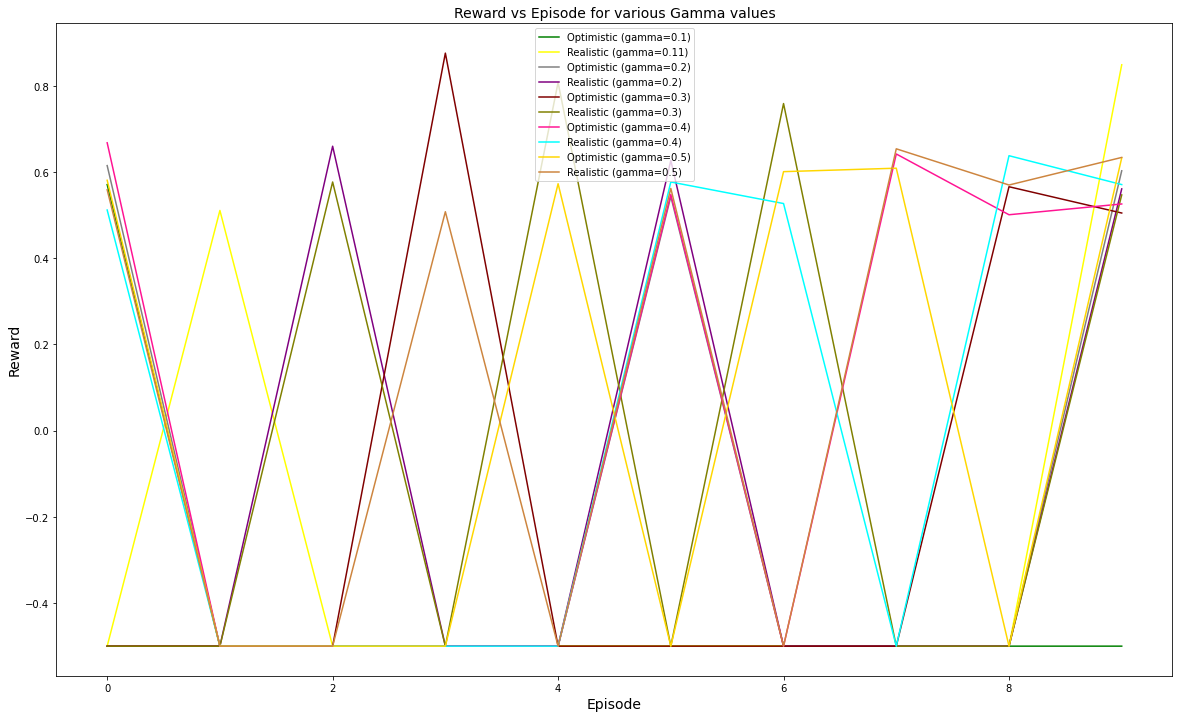

In [27]:
# visulisation for Reward vs Episode for various gamma values
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))

plt.plot(optimistic_exp1, color='green', label = 'Optimistic (gamma=0.1)')
plt.plot(realistic_exp1, color='yellow',  label='Realistic (gamma=0.11)')

plt.plot(optimistic_exp2, color='grey',  label = 'Optimistic (gamma=0.2)')
plt.plot(realistic_exp2, color='purple',  label='Realistic (gamma=0.2)')

plt.plot(optimistic_exp3, color='maroon',  label = 'Optimistic (gamma=0.3)')
plt.plot(realistic_exp3, color='olive', label='Realistic (gamma=0.3)')

plt.plot(optimistic_exp4, color='deeppink',  label = 'Optimistic (gamma=0.4)')
plt.plot(realistic_exp4, color='cyan', label='Realistic (gamma=0.4)')

plt.plot(optimistic_exp5, color='gold',  label = 'Optimistic (gamma=0.5)')
plt.plot(realistic_exp5, color='peru',  label='Realistic (gamma=0.5)')

plt.title('Reward vs Episode for various Gamma values', fontsize=14)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.legend()
plt.show()